# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import os

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

# Load Dataset

In [19]:
df = pd.read_csv("Global Superstore.csv", encoding="latin1")

# Fix duplicate column names
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

df = df.loc[:, ~df.columns.duplicated()].copy()

print(df.columns.tolist())

['category', 'city', 'country', 'customer.id', 'customer.name', 'discount', 'market', 'è®°å½\x95æ\x95°', 'order.date', 'order.id', 'order.priority', 'product.id', 'product.name', 'profit', 'quantity', 'region', 'row.id', 'sales', 'segment', 'ship.date', 'ship.mode', 'shipping.cost', 'state', 'sub.category', 'year', 'market2', 'weeknum']


# Normalize Column Names to Friendly snake_case

In [3]:
def clean_col(c):
    c = c.strip()
    c = c.replace(".", " ").replace("/", " ").replace("-", " ")
    c = "_".join(c.split())
    return c.lower()

df.columns = [clean_col(c) for c in df.columns]
print("Columns detected (sample):", df.columns.tolist()[:30])

Columns detected (sample): ['category', 'city', 'country', 'customer_id', 'customer_name', 'discount', 'market', 'è®°å½\x95æ\x95°', 'order_date', 'order_id', 'order_priority', 'product_id', 'product_name', 'profit', 'quantity', 'region', 'row_id', 'sales', 'segment', 'ship_date', 'ship_mode', 'shipping_cost', 'state', 'sub_category', 'year', 'market2', 'weeknum']


# Map common expected names to standard names used below

In [4]:
col_map = {}

## Find Candidates

In [5]:
# find candidates
for col in df.columns:
    if "order" in col and "date" in col:
        col_map[col] = "order_date"
    if col in ["region","market","market2"]:
        col_map[col] = "region"
    if "sub" in col and "category" in col:
        col_map[col] = "sub_category"
    if "category" in col and "sub" not in col:
        col_map[col] = "category"
    if "customer_name" in col or "customer" in col and "name" in col:
        col_map[col] = "customer_name"
    if col == "sales" or "sales" in col:
        col_map[col] = "sales"
    if col == "profit" or "profit" in col:
        col_map[col] = "profit"
    if "quantity" in col:
        col_map[col] = "quantity"
    if "discount" in col:
        col_map[col] = "discount"
    if "ship_date" in col:
        col_map[col] = "ship_date"
    if "order_id" in col:
        col_map[col] = "order_id"
    if "customer_id" in col or "customer.id" in col:
        col_map[col] = "customer_id"

## Apply Mapping (only if detected)

In [6]:
df = df.rename(columns=col_map)
print("After mapping, key columns present:", [c for c in ["order_date","region","category","sub_category","sales","profit","customer_name"] if c in df.columns])

After mapping, key columns present: ['order_date', 'region', 'category', 'sub_category', 'sales', 'profit', 'customer_name']


# Parse Dates Robustly

In [7]:
if "order_date" in df.columns:
    # many csvs have timestamps like '2011-01-09 00:00:00.000'
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce', infer_datetime_format=True)
else:
    # try other candidates
    possible_date_cols = [c for c in df.columns if 'date' in c]
    if possible_date_cols:
        df['order_date'] = pd.to_datetime(df[possible_date_cols[0]], errors='coerce', infer_datetime_format=True)
    else:
        raise ValueError("No date column found. Please inspect columns: " + ", ".join(df.columns))

C:\Users\pc\AppData\Local\Temp\ipykernel_15916\1276536762.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce', infer_datetime_format=True)


# Data Preprocessing

## Standardize sales & profit

In [8]:
for num_col in ['sales','profit','quantity','discount','shipping_cost','shipping.cost','shipping_cost']:
    if num_col in df.columns:
        df[num_col] = pd.to_numeric(df[num_col], errors='coerce')

## Try to find sales/profit if not yet mapped

In [9]:
if 'sales' not in df.columns:
    cand = [c for c in df.columns if 'sales' in c]
    if cand:
        df = df.rename(columns={cand[0]:'sales'})
        df['sales'] = pd.to_numeric(df['sales'], errors='coerce')

if 'profit' not in df.columns:
    cand = [c for c in df.columns if 'profit' in c]
    if cand:
        df = df.rename(columns={cand[0]:'profit'})
        df['profit'] = pd.to_numeric(df['profit'], errors='coerce')

## Fill numeric NaNs with 0 for sales/profit (business logic: missing -> 0)

In [10]:
for c in ['sales','profit','quantity']:
    if c in df.columns:
        df[c] = df[c].fillna(0.0)

## Fill categorical NAs

In [11]:
for c in ['region','category','sub_category','customer_name']:
    if c in df.columns:
        df[c] = df[c].astype(str).fillna('Unknown')

## Drop rows without order_date

In [12]:
df = df[~df['order_date'].isna()].copy()
df.reset_index(drop=True, inplace=True)

print("Data range:", df['order_date'].min(), "to", df['order_date'].max())
print("Rows after cleaning:", df.shape[0])

Data range: 2011-01-01 00:00:00 to 2014-12-31 00:00:00
Rows after cleaning: 51290


# Derive Time Features

In [13]:
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['year_month'] = df['order_date'].dt.to_period('M').astype(str)
df['week'] = df['order_date'].dt.isocalendar().week

# KPIs Overall

In [14]:
total_sales = df['sales'].sum()
total_profit = df['profit'].sum()
total_orders = df['order_id'].nunique() if 'order_id' in df.columns else df.shape[0]
avg_order_value = total_sales / total_orders if total_orders else 0.0
profit_margin = (total_profit / total_sales * 100.0) if total_sales else 0.0

print(f"Total Sales: ${total_sales:,.2f}")
print(f"Total Profit: ${total_profit:,.2f}")
print(f"Total Orders: {total_orders:,}")
print(f"Avg Order Value: ${avg_order_value:,.2f}")
print(f"Profit Margin: {profit_margin:.2f}%")

Total Sales: $12,642,905.00
Total Profit: $1,467,457.29
Total Orders: 25,035
Avg Order Value: $505.01
Profit Margin: 11.61%


# Time Series: Monthly Sales & Profit

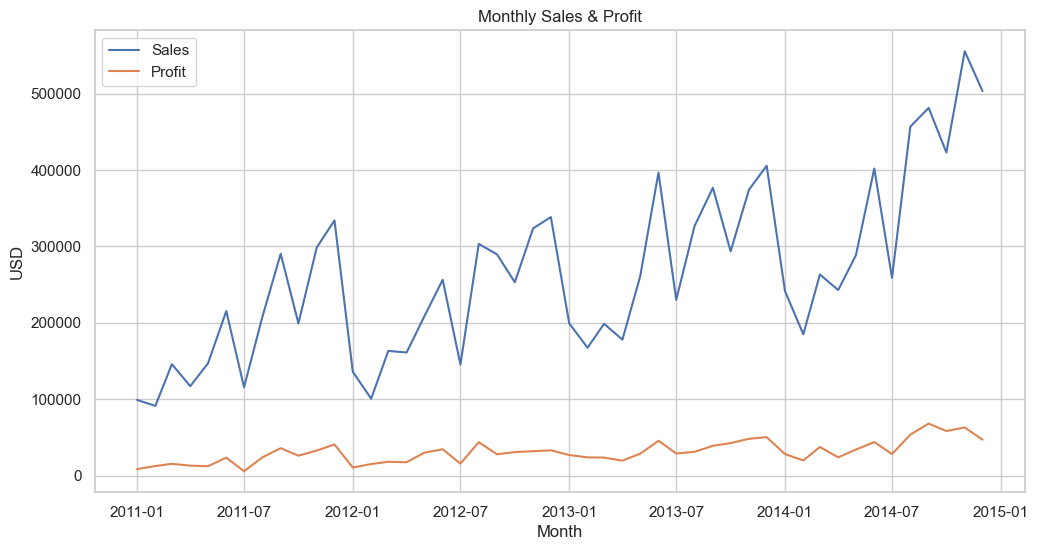

In [15]:
monthly = df.groupby('year_month').agg(
    total_sales=('sales','sum'),
    total_profit=('profit','sum'),
    orders=('order_id' if 'order_id' in df.columns else 'sales','count')
).reset_index()
monthly['year_month_dt'] = pd.to_datetime(monthly['year_month'] + '-01')

plt.figure()
plt.plot(monthly['year_month_dt'], monthly['total_sales'], label='Sales')
plt.plot(monthly['year_month_dt'], monthly['total_profit'], label='Profit')
plt.title("Monthly Sales & Profit")
plt.xlabel("Month")
plt.ylabel("USD")
plt.legend()
plt.show()

# Sales by Category & Sub-Category

,category,sales,profit
2,Technology,4744691,663778.73318
0,Furniture,4110884,285204.72380
1,Office Supplies,3787330,518473.83430


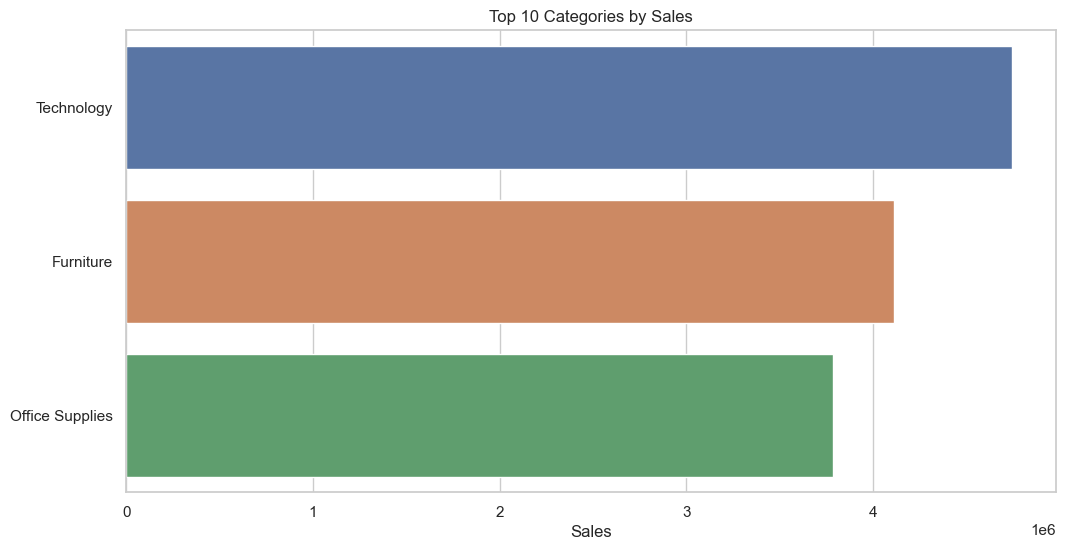

,sub_category,sales,profit
13,Phones,1706874,216717.00580
6,Copiers,1509439,258567.54818
5,Chairs,1501682,140396.26750
4,Bookcases,1466559,161924.41950
14,Storage,1127124,108461.48980
1,Appliances,1011081,141680.58940
11,Machines,779071,58867.87300
16,Tables,757034,-64083.38870
0,Accessories,749307,129626.30620
3,Binders,461952,72449.84600


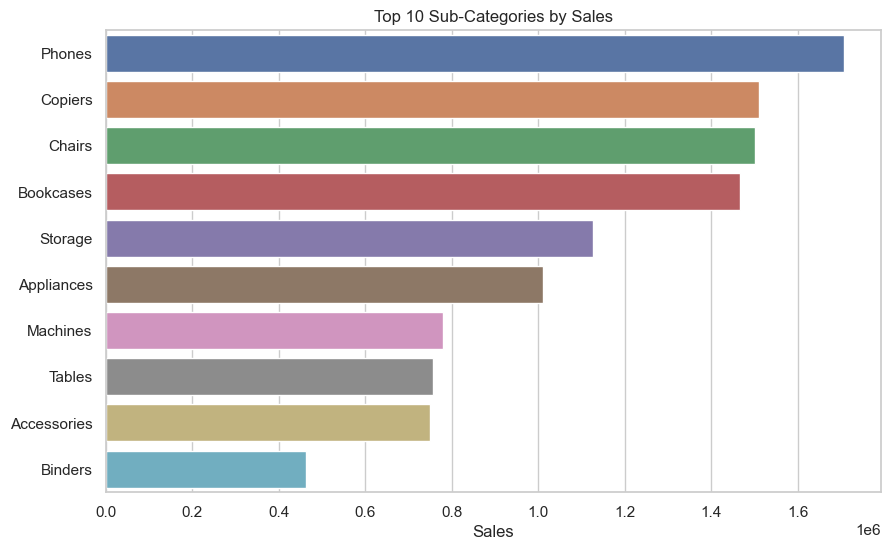

In [16]:
if 'category' in df.columns:
    cat_sales = df.groupby('category').agg(sales=('sales','sum'), profit=('profit','sum')).reset_index().sort_values('sales', ascending=False)
    display(cat_sales.head(10))

    plt.figure()
    sns.barplot(data=cat_sales.head(10), x='sales', y='category')
    plt.title("Top 10 Categories by Sales")
    plt.xlabel("Sales")
    plt.ylabel("")
    plt.show()

if 'sub_category' in df.columns:
    sub_sales = df.groupby('sub_category').agg(sales=('sales','sum'), profit=('profit','sum')).reset_index().sort_values('sales', ascending=False)
    display(sub_sales.head(10))

    plt.figure(figsize=(10,6))
    sns.barplot(data=sub_sales.head(10), x='sales', y='sub_category')
    plt.title("Top 10 Sub-Categories by Sales")
    plt.xlabel("Sales")
    plt.ylabel("")
    plt.show()

# Sales by Region / Market

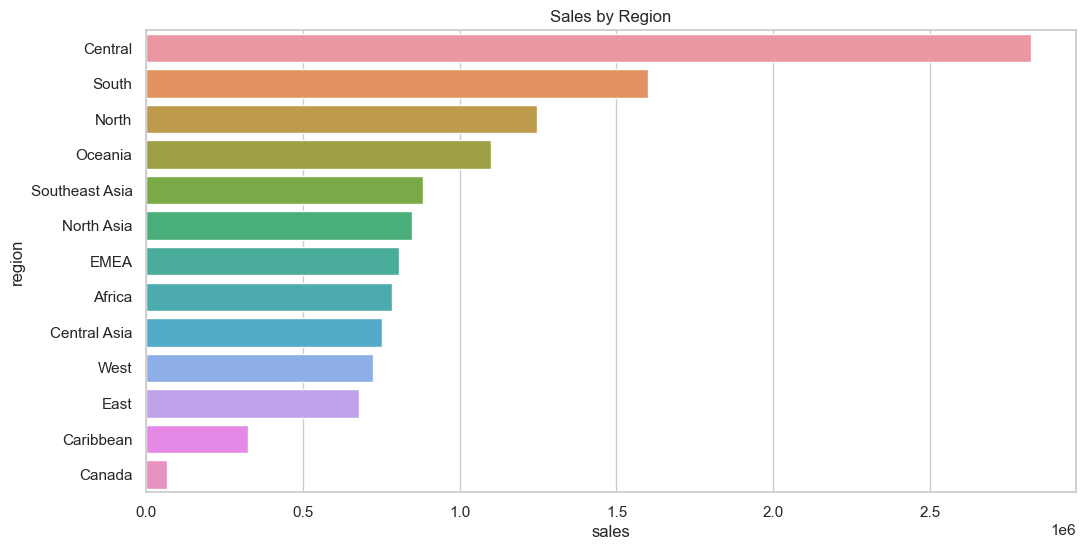

In [20]:
region_sales = (
    df.groupby('region', as_index=False)
      .agg(sales=('sales','sum'), profit=('profit','sum'))
      .sort_values('sales', ascending=False)
)
sns.barplot(data=region_sales, x='sales', y='region')
plt.title("Sales by Region")
plt.show()

# Save Summary Outputs for Dashboard / Report

In [25]:
os.makedirs("data/outputs", exist_ok=True)
monthly[['year_month','total_sales','total_profit']].to_csv("data/outputs/monthly_sales_summary.csv", index=False)
if 'category' in df.columns:
    cat_sales.to_csv("data/outputs/category_sales_summary.csv", index=False)
if 'sub_category' in df.columns:
    sub_sales.to_csv("data/outputs/subcategory_sales_summary.csv", index=False)
if 'customer_name' in df.columns:
    top_customers.to_csv("data/outputs/top_customers.csv", index=False)

print("Saved summary CSVs to data/outputs/")

Saved summary CSVs to data/outputs/


# Notes / Next Steps

Next suggestions:
- Build the Streamlit dashboard (app.py) using these summary CSVs
- Add filters and interactivity (region, category, sub-category)
- Add rolling averages and YoY comparisons if required